In [1]:
using Distributed
addprocs(44);

In [2]:
using pulse_input_DDM

┌ Info: Recompiling stale cache file /usr/people/briandd/.julia/compiled/v1.2/pulse_input_DDM/m8WoA.ji for pulse_input_DDM [c2542da2-1f7d-11e9-2506-87691095ebb2]
└ @ Base loading.jl:1240
  ** incremental compilation may be fatally broken for this module **



In [3]:
path = "/usr/people/briandd/Projects/neural_DDM_analysis/data/hanks_data_sessions"

"/usr/people/briandd/Projects/neural_DDM_analysis/data/hanks_data_sessions"

In [ ]:
#ratnames = ["B068","T034","T036","T063","T030"] #FOF
#ratnames = ["T035","T011","B053"] PPC
#ratnames = ["T080","T103","E021"] #STR

In [169]:
region, rat = "FOF", "T063"

("FOF", "T063")

In [185]:
sessions = filter(x->occursin(rat,x), readdir(path))

17-element Array{String,1}:
 "T063_191956.mat"
 "T063_193936.mat"
 "T063_194554.mat"
 "T063_194649.mat"
 "T063_194770.mat"
 "T063_194898.mat"
 "T063_195271.mat"
 "T063_195546.mat"
 "T063_195676.mat"
 "T063_195791.mat"
 "T063_196336.mat"
 "T063_196580.mat"
 "T063_196708.mat"
 "T063_197075.mat"
 "T063_197212.mat"
 "T063_197479.mat"
 "T063_198004.mat"

In [82]:
output = load.(joinpath.(path, sessions[end-2:end]), false, delay=0.05);

In [83]:
data = getindex.(output, 1);

In [84]:
f, ncells, ntrials, nparams = "Softplus", map(x-> x[1].ncells, data), length.(data), 3
#f, ncells, ntrials, nparams = "Sigmoid", map(x-> x[1].ncells, data), length.(data), 4

("Softplus", [3, 3, 4], [389, 339, 431], 3)

In [85]:
θ_syn = θneural(θz = θz(σ2_i = 0.5, B = 40., λ = -0.5, σ2_a = 50., σ2_s = 0.1,
    ϕ = 0.6, τ_ϕ =  0.02),
    θy=[[Softplus(10., rand([-1.,1.]),0.) for n in 1:N] for N in ncells], ncells=ncells,
    nparams=nparams, f=f)

#θ_syn = θneural(θz = θz(σ2_i = 0.5, B = 40., λ = -0.5, σ2_a = 50., σ2_s = 0.1,
#    ϕ = 0.6, τ_ϕ =  0.02),
#    θy=[[Sigmoid(10., 10., rand([-1.,1.]), 0.) for n in 1:N] for N in ncells], ncells=ncells,
#    nparams=nparams, f=f)

θneural{θz{Float64},Array{Array{Softplus{Float64},1},1}}
  θz: θz{Float64}
  θy: Array{Array{Softplus{Float64},1}}((3,))
  ncells: Array{Int64}((3,)) [3, 3, 4]
  nparams: Int64 3
  f: String "Softplus"


In [86]:
data, μ_rnt, μ_t = synthetic_data(θ_syn, ntrials; centered=true);

In [87]:
output = pulse_input_DDM.process_spike_data.(μ_rnt, data, ncells; nconds=2);

In [88]:
μ_ct = getindex.(output, 1)
σ_ct = getindex.(output, 2);

In [89]:
_, μ_c_λ = pulse_input_DDM.synthetic_λ(θ_syn, data; num_samples=100, nconds=2);

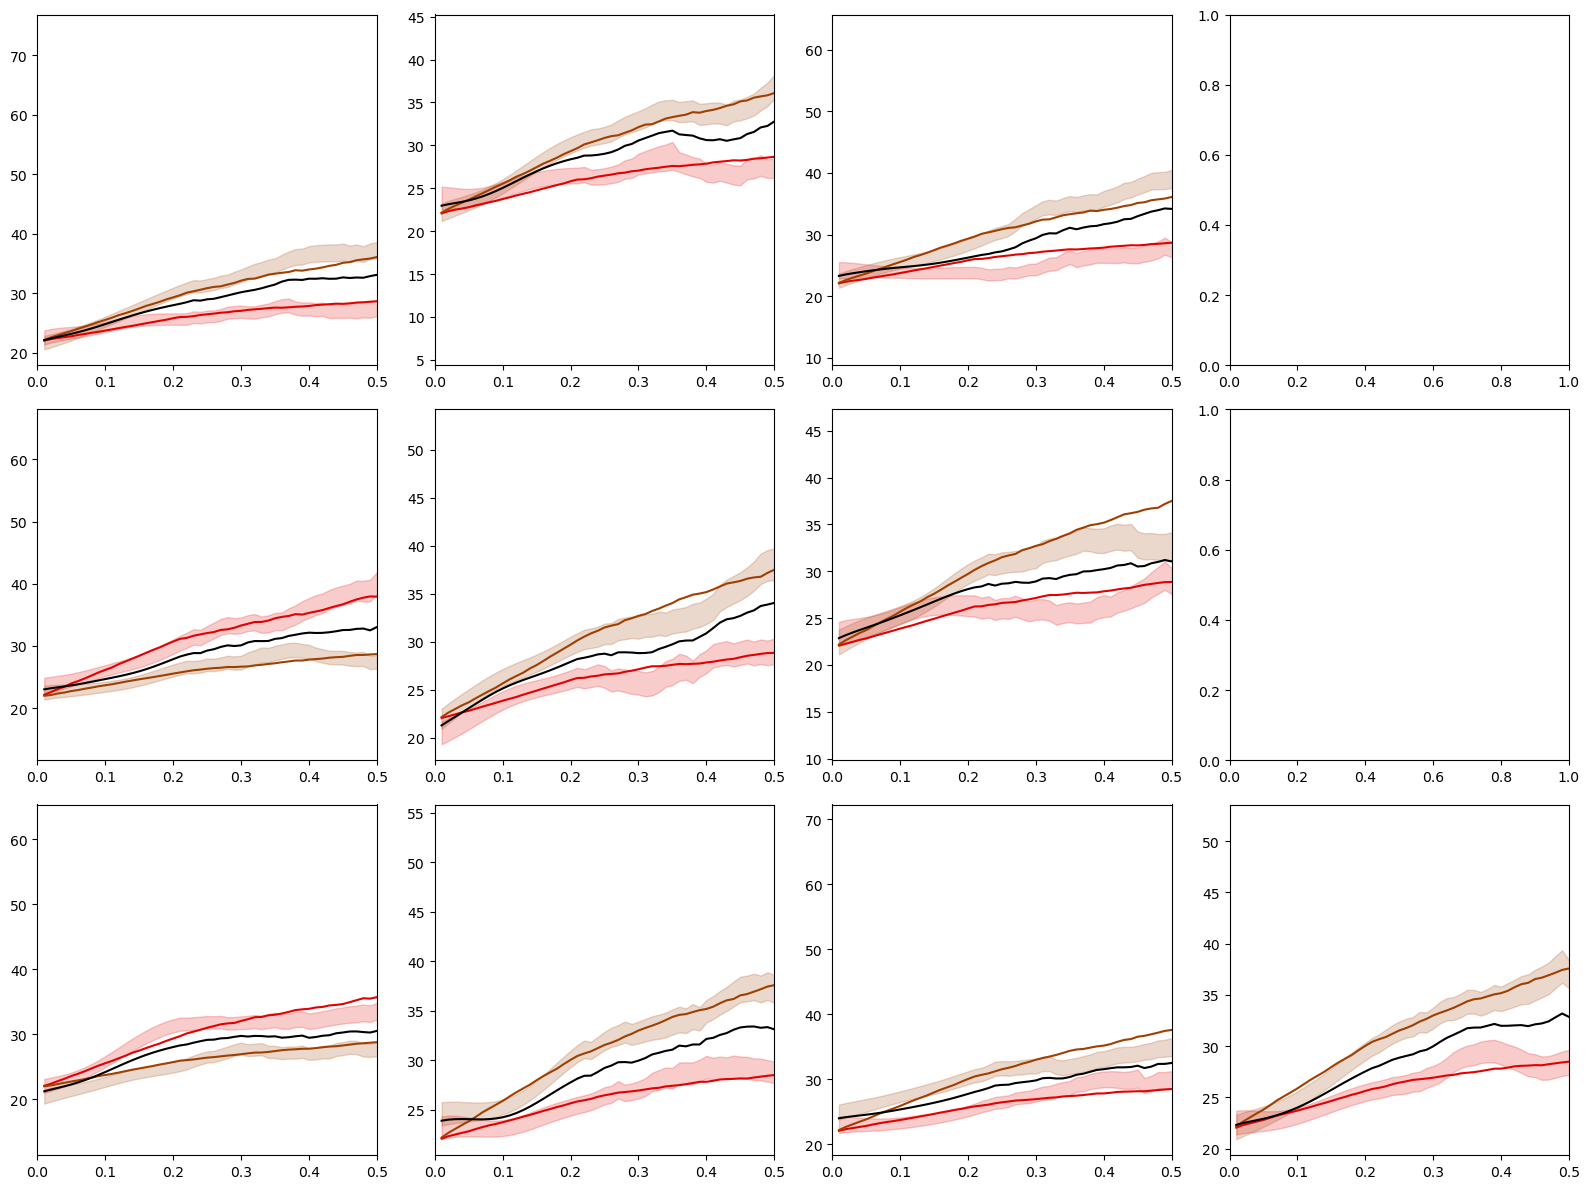

In [90]:
using PyPlot

dt = 1e-2

num_rows, num_cols = length(data), maximum(map(x-> x[1].ncells, data))
fig, ax = subplots(num_rows, num_cols, figsize=(4*maximum(map(x-> x[1].ncells, data)), 4*length(data)))
my_colors = ["#E50000","#9F3F00","#5A7F00","#15BF00"]

for i in 1:num_rows
        
    for j in 1:data[i][1].ncells             
        for k = 1:2     

            ax[i,j].fill_between((1:length(μ_ct[i][j][k]))*dt,
                μ_ct[i][j][k] + σ_ct[i][j][k],
                μ_ct[i][j][k] - σ_ct[i][j][k],
                alpha=0.2, color=my_colors[k])

            ax[i,j].plot((1:length(μ_c_λ[i][j][k]))*dt,
                μ_c_λ[i][j][k], color=my_colors[k])                                     

            ax[i,j].set_xlim((0, 0.5))
                        
        end   
        
        ax[i,j].plot((1:length(μ_t[i][j]))*dt,
            μ_t[i][j], color="black")

    end
    
end

tight_layout() 

In [91]:
θy0 = vcat(vcat(initialize_θy.(data, f)...)...);

In [97]:
#options0 = neuraloptions(ncells=ncells,
#    fit=vcat(falses(dimz), trues(sum(ncells)*nparams)),
#    x0=vcat([0., 30., 0. + eps(), 0., 0., 1. - eps(), 0.008], θy0),
#    nparams=nparams, f=f, 
#    lb = vcat([0., 8., -5., 0., 0., 0.01, 0.005], repeat([0.,-10.,-10.,], sum(ncells))), 
#    ub = vcat([2., 30., 5., 100., 2.5, 1.2, 1.], repeat([100.,10.,10.], sum(ncells))))

#options0 = neuraloptions(ncells=ncells,
#    fit=vcat(falses(dimz), trues(sum(ncells)*nparams)),
#    x0=vcat(pulse_input_DDM.flatten(θ_syn)[1:dimz], θy0),
#    nparams=nparams, f=f, 
#    lb = vcat([0., 8., -5., 0., 0., 0.01, 0.005], repeat([0.,-10.,-10.,], sum(ncells))), 
#    ub = vcat([2., 30., 5., 100., 2.5, 1.2, 1.], repeat([100.,10.,10.], sum(ncells))))

#options = neuraloptions(ncells=ncells, 
#    x0=vcat(pulse_input_DDM.flatten(θ_syn)[1:dimz], θy0),
#    fit=vcat(trues(dimz), trues(sum(ncells)*nparams)), nparams=nparams, f=f, 
#    lb = vcat([0., 8., -5., 0.,   0.,  0.01, 0.005], repeat([0.,-100.,-100.,], sum(ncells))), 
#    ub = vcat([2., 50., 5., 100., 2.5, 1.2,  1.], repeat([100.,100.,100.], sum(ncells))))

options = neuraloptions(ncells=ncells, 
    x0=vcat([0.1, 12., -2., 10., 0.1, 0.8, 0.008], θy0),
    fit=vcat(trues(dimz), trues(sum(ncells)*nparams)), nparams=nparams, f=f, 
    lb = vcat([0., 8., -5., 0.,   0.,  0.01, 0.005], repeat([0.,-100.,-100.,], sum(ncells))), 
    ub = vcat([2., 50., 5., 100., 2.5, 1.2,  1.], repeat([100.,100.,100.], sum(ncells))))

#options0 = neuraloptions(ncells=ncells,
#    fit=vcat(falses(dimz), trues(sum(ncells)*nparams)),
#    x0=vcat(pulse_input_DDM.flatten(θ_syn)[1:dimz], θy0),
#    nparams=nparams, f=f)

#options0 = neuraloptions(ncells=ncells,
#    fit=vcat(falses(dimz), trues(sum(ncells)*nparams)),
#    x0=pulse_input_DDM.flatten(θ_syn),
#    nparams=nparams, f=f)

neuraloptions
  ncells: Array{Int64}((3,)) [3, 3, 4]
  nparams: Int64 3
  f: String "Softplus"
  fit: Array{Bool}((37,)) Bool[1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
  lb: Array{Float64}((37,)) [0.0, 8.0, -5.0, 0.0, 0.0, 0.01, 0.005, 0.0, -100.0, -100.0  …  -100.0, 0.0, -100.0, -100.0, 0.0, -100.0, -100.0, 0.0, -100.0, -100.0]
  ub: Array{Float64}((37,)) [2.0, 50.0, 5.0, 100.0, 2.5, 1.2, 1.0, 100.0, 100.0, 100.0  …  100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]
  x0: Array{Float64}((37,)) [0.1, 12.0, -2.0, 10.0, 0.1, 0.8, 0.008, 26.90614136732329, 0.33209603259851206, 0.0  …  0.0, 25.515947467166978, 0.29732352318366817, 0.0, 26.165703275529868, 0.24507130251116516, 0.0, 25.69364161849711, 0.3100293856902339, 0.0]


In [98]:
n = 53
loglikelihood(θ_syn, data, n)

-161397.4652985499

In [99]:
model, = optimize(data, options, n)

Fminbox
-------
Initial mu = 0.013256

Fminbox iteration 1
-------------------
Calling inner optimizer with mu = 0.013256

(numbers below include barrier contribution)
Iter     Function value   Gradient norm 
     0     1.675086e+05     2.584311e+03
 * time: 4.887580871582031e-5
     1     1.673894e+05     8.514133e+01
 * time: 6.019527912139893
     2     1.671369e+05     1.557258e+02
 * time: 12.033516883850098
     3     1.670110e+05     8.271493e+01
 * time: 18.03927993774414
     4     1.669587e+05     8.255681e+01
 * time: 24.20033597946167
     5     1.667639e+05     8.109112e+01
 * time: 30.188284873962402
     6     1.665969e+05     9.345513e+01
 * time: 36.074059009552
     7     1.664169e+05     1.003445e+02
 * time: 41.94226908683777
     8     1.662616e+05     1.474925e+02
 * time: 47.7937798500061
     9     1.661063e+05     1.465297e+02
 * time: 53.549174070358276
    10     1.659700e+05     1.723145e+02
 * time: 59.21080708503723
    11     1.658254e+05     1.812642e+02

   117     1.614570e+05     2.203484e+02
 * time: 710.764524936676
   118     1.614569e+05     2.199926e+02
 * time: 716.7657010555267
   119     1.614541e+05     1.918472e+01
 * time: 722.8587000370026
   120     1.614527e+05     1.920690e+01
 * time: 728.8431298732758
   121     1.614521e+05     7.600279e+02
 * time: 734.8356449604034
   122     1.614521e+05     1.794537e+02
 * time: 767.7676570415497
   123     1.614521e+05     2.493612e+01
 * time: 794.6088168621063
   124     1.614516e+05     2.016839e+01
 * time: 806.6026210784912
   125     1.614357e+05     6.932519e+01
 * time: 812.6078519821167
   126     1.614147e+05     7.720485e+01
 * time: 818.6128070354462
   127     1.613998e+05     1.092275e+02
 * time: 824.7885489463806
   128     1.613966e+05     6.823128e+01
 * time: 833.9744598865509
   129     1.613945e+05     4.650225e+01
 * time: 843.1025199890137
   130     1.613906e+05     6.235001e+01
 * time: 852.1193718910217
   131     1.613906e+05     6.054163e+01
 * time:

   237     1.613781e+05     7.410523e-01
 * time: 1540.5035319328308
   238     1.613781e+05     7.310430e-01
 * time: 1546.5978329181671
   239     1.613781e+05     7.211140e-01
 * time: 1552.6745960712433
   240     1.613781e+05     7.119481e-01
 * time: 1558.87890291214
   241     1.613781e+05     7.032907e-01
 * time: 1565.1641528606415
   242     1.613781e+05     6.942823e-01
 * time: 1571.2185850143433
   243     1.613781e+05     6.975918e-01
 * time: 1577.285348892212
   244     1.613781e+05     7.038643e-01
 * time: 1583.3408629894257
   245     1.613781e+05     7.230597e-01
 * time: 1589.3946418762207
   246     1.613781e+05     7.214958e-01
 * time: 1595.3926339149475

Exiting inner optimizer with x = [0.017464688563344485, 39.06857212190017, 0.30003890610011724, 95.08584467041321, 0.4080606492146318, 1.0112479550534692, 0.5263697177471791, 9.5894236620562, 0.5285636262329144, 1.1933660596316518, 8.068221151560454, 0.395167534009781, 4.066623757074908, 8.185312602765034, 0.54

     6     1.613811e+05     1.688102e+00
 * time: 42.29639291763306

Exiting inner optimizer with x = [1.6810518360109742e-5, 35.56582286591641, 0.2651618877018071, 95.02856430769472, 0.13603954620232067, 1.1999992573109675, 0.15977298019485403, 9.603797965238718, 0.5835976876863327, 1.1530157965975125, 8.072858020593824, 0.4364328634238512, 4.0522556860322, 8.186798217369374, 0.59613148749414, 2.666775034124974, 10.672300046999075, -0.6088444550252309, -1.0996795942461068, 9.505585415863488, 0.5681253104574558, 1.4016753734048564, 9.824162952407718, 0.36698125730792186, 1.0790635778961923, 9.823395528355364, -0.5058227348502604, 0.6647090435371641, 10.292850855524987, 0.5672970251960185, -0.010399374012834188, 10.214909651022342, 0.4567749688029804, 0.8332888788234242, 10.093469322766417, 0.6492418435826304, -1.2816898788137217]
Current distance to box: 7.42689e-7
Decreasing barrier term μ.

Fminbox iteration 4
-------------------
Calling inner optimizer with mu = 1.3256e-11

(numbers

neuralDDM{θneural{θz{Float64},Array{Array{Softplus{Float64},1},1}},Array{Array{neuraldata,1},1}}
  θ: θneural{θz{Float64},Array{Array{Softplus{Float64},1},1}}
  data: Array{Array{neuraldata,1}}((3,))


In [100]:
μ_λ, μ_c_λ = pulse_input_DDM.synthetic_λ(model.θ, data; num_samples=100, nconds=2);

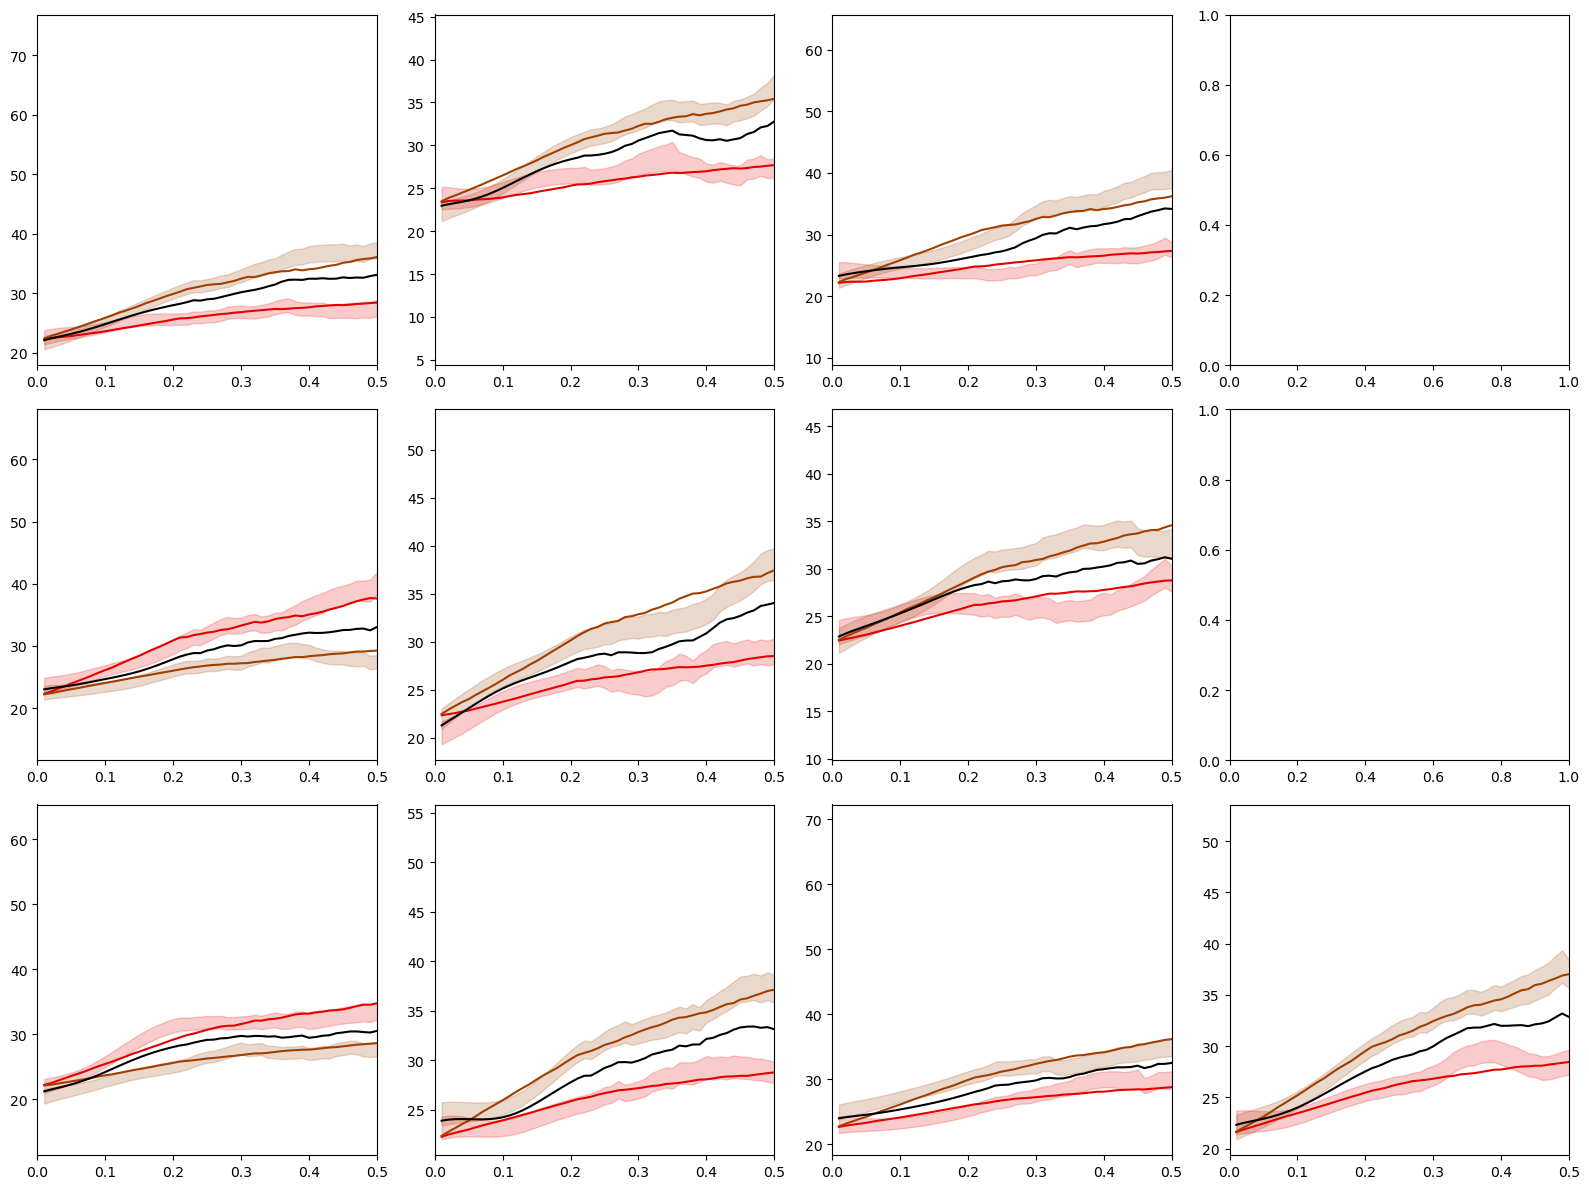

In [101]:
using PyPlot

dt = 1e-2

num_rows, num_cols = length(data), maximum(map(x-> x[1].ncells, data))
fig, ax = subplots(num_rows, num_cols, figsize=(4*maximum(map(x-> x[1].ncells, data)), 4*length(data)))
my_colors = ["#E50000","#9F3F00","#5A7F00","#15BF00"]
#PPC colors = ["#1822A0","#5D4A7A","#A37354","#E99C2F"]
#STR colors = ["#A01892","#B85C71","#D0A150","#E9E62F"]

for i in 1:num_rows
        
    for j in 1:data[i][1].ncells             
        for k = 1:2     

            ax[i,j].fill_between((1:length(μ_ct[i][j][k]))*dt,
                μ_ct[i][j][k] + σ_ct[i][j][k],
                μ_ct[i][j][k] - σ_ct[i][j][k],
                alpha=0.2, color=my_colors[k])

            ax[i,j].plot((1:length(μ_c_λ[i][j][k]))*dt,
                μ_c_λ[i][j][k], color=my_colors[k])                                     

            ax[i,j].set_xlim((0, 0.5))
                        
        end   
        
        ax[i,j].plot((1:length(μ_t[i][j]))*dt,
            μ_t[i][j], color="black")

    end
    
end

tight_layout() 